### 10/31, ここまでの結果について検討してみる
* Stratified-KFoldだと、F1-scoreでCVが0.71を超えたあたりからLBが下がり始める
* そこの境目でCVを組む指針を得られないか

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import torch
import torch.nn as nn

logits = nn.Softmax(dim=1)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 20000)

* 条件を揃えるために、compare-batchのシリーズを並べてみる

In [3]:
data_path_list = [
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch64/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch32_acc2/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch16_acc4/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch8_acc8/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch4_acc16/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch2_acc32/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch1_acc64/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch32/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch16_acc2/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch8_acc4/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch4_acc8/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch2_acc16/",
    "/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/compare_batch_accum_roberta_large_cat4_batch1_acc32/",
]

In [4]:
score_df = pd.DataFrame(
    [[0.710,0.683168,0.677548],
    [0.647,0.637636,0.633245],
    [0.663,0.623003,0.610357],
    [0.729,0.670968,0.668412],
    [0.691,0.6304,0.62643],
    [0.666,0.636204,0.6313],
    [0.702,0.627329,0.633061],
    [0.716,0.732919,0.733826],
    [0.720,0.700348,0.695671],
    [0.708,0.664495,0.657493],
    [0.754,0.703125,0.70568,],
    [0.673,0.651828,0.648188],
    [0.708,0.692668,0.691746]],
    columns=["LB", "allCV", "meanCV"]
)

Text(0.2, 0.76, 'LB-meanCV corr: 0.747')

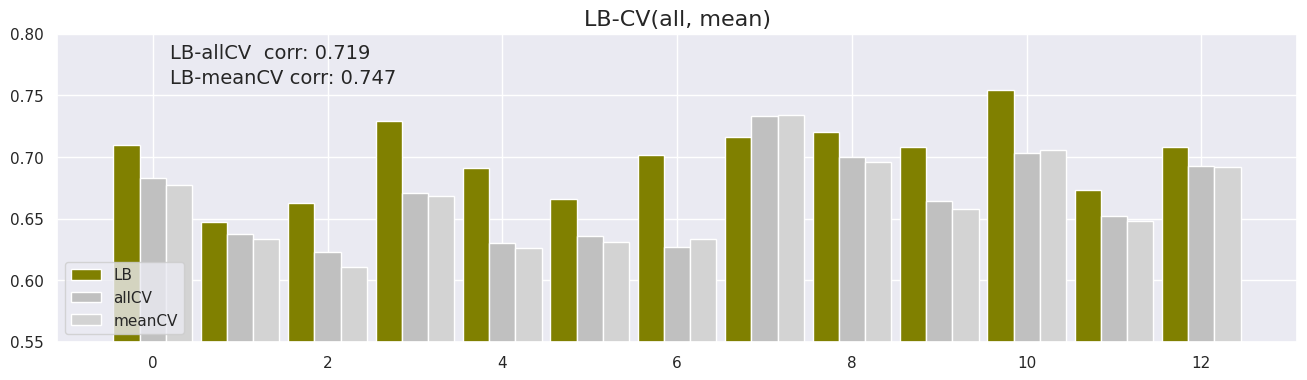

In [5]:
fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(16, 4))

ax.bar(x=score_df.index-0.3, height=score_df.loc[:, "LB"], align="center", width=0.3, color="olive", edgecolor=None, label="LB")
ax.bar(x=score_df.index, height=score_df.loc[:, "allCV"], align="center", width=0.3, color="silver", edgecolor=None, label="allCV")
ax.bar(x=score_df.index+0.3, height=score_df.loc[:, "meanCV"], align="center", width=0.3, color="lightgray", edgecolor=None, label="meanCV")
ax.legend(loc="lower left")
ax.set_title("LB-CV(all, mean)", fontsize=16)
ax.set_ylim([0.55, 0.8])

ax.text(x=0.2, y=0.78, s=f"LB-allCV  corr: {score_df.corr().iat[0, 1]:.3f}", fontsize=14)
ax.text(x=0.2, y=0.76, s=f"LB-meanCV corr: {score_df.corr().iat[0, 2]:.3f}", fontsize=14)

(0.55, 0.8)

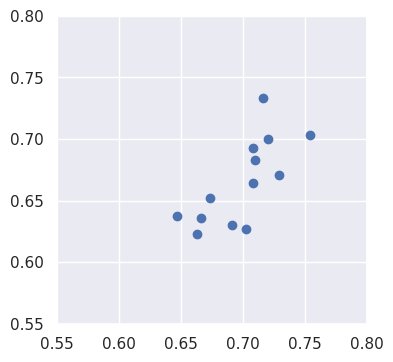

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(score_df["LB"], score_df["allCV"])
ax.set_xlim([0.55, 0.8]); ax.set_ylim([0.55, 0.8])

In [7]:
result_df = []
for i, path in enumerate(data_path_list):
    train_df = pd.read_feather(path+"train_df.feather")
    test_df = pd.read_feather(path+"test_df.feather")

    df = pd.concat([train_df, test_df])

    t = pd.DataFrame(
        logits(torch.Tensor(df.loc[:, ["model_oof_class_0", "model_oof_class_1"]].values)).numpy()[:, 1],
        columns=[f"proba_{i}"]
        )
    result_df.append(t)
result_df = pd.concat(result_df, axis=1).reset_index(drop=True)

In [8]:
result_df = pd.concat(
    [df.loc[:, ["id", "source", "text", "clean_text", "label", "kfold"]].reset_index(drop=True), result_df], 
    axis=1
    )

In [9]:
result_df.head(2)

,id,source,text,clean_text,label,kfold,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10,proba_11,proba_12
0,80074aa43,news4vip,まともに相手されてない人との関係なんて\nそんな大事にするものか？,まともに 相手 さ れて ない 人 と の 関係 なんて そんな 大事に する もの か ?,0.0,0.0,0.000042,3.789167e-05,0.000001,0.000043,0.000001,0.000003,0.000001,0.000019,0.000048,7.010696e-08,0.000024,3.721301e-07,1.557632e-07
1,6378fea6b,livejupiter,最近はアヘアヘQSマンやない？ ｲｲ!(・∀・)+1-0(・Ａ・)ｲｸﾅｲ!,最近 は アヘアヘ QS マン や ない ? イイ ! ( ・ ∀ ・ ) + 1 - 0 (・A・) イクナイ !,0.0,4.0,0.000005,7.369123e-07,0.000031,0.000006,0.000007,0.000024,0.000007,0.000007,0.000007,5.389698e-06,0.000019,1.274428e-07,1.911447e-06


### 予測の数を並べる

In [10]:
for i in range(13):
    result_df[f"model_pred_{i}"] = result_df.loc[:, f"proba_{i}"].map(lambda x: 1 if x>0.5 else 0)

In [11]:
result_df["model_preds_all"] = result_df.iloc[:, 19:].sum(axis=1)

In [12]:
result_df["model_preds_all"].value_counts().sort_index()

0     7594
1      146
2       64
3       55
4       41
5       43
6       36
7       41
8       45
9       29
10      39
11      59
12      65
13     222
Name: model_preds_all, dtype: int64

In [13]:
result_df[result_df["model_preds_all"] == 10].loc[:, ["source","label","text"]]

,source,label,text
304,news4vip,1.0,汚いんだよ\n今の日本人男なんかぜんぶオカマの癖に
458,news4vip,1.0,大声だして憂さ晴らししたり自分より弱そうな地元の人達を脅したりして日当3万か\nチョンはそんなクソ人生でも楽しいだろうな\nなんせチョンはクソで出来ているから
610,livejupiter,1.0,まあ在日韓国人は金貰ってるくせに反日だし犯罪しまくってるから嫌われてとうぜんです
972,news4vip,0.0,そんなんだから負け犬なんだろ\n憂国者（）の若者は結局日本人叩きしか出来ない負け犬
1050,newsplus,1.0,土を耕してくれるミミズに謝れ\n中国は土地を汚染するだけ
1211,livejupiter,1.0,モンゴロイドはダウン症の顔、奇形だから遺伝子残さず絶滅すべき
1665,livejupiter,0.0,ガイジに何言っても始まらんやろ\n関西ならガイジでも天かすです通じるんだから引っ越せや
1684,news4vip,0.0,DQNは群れるし怖いだろ\n毎日軽犯罪犯してるキチガイとか近づきたくない
2251,livejupiter,1.0,日本にアイヌと蝦夷と熊襲と琉球の混じった人間はいらない
2519,livejupiter,1.0,女の被害者意識が強すぎるのもあるやろ\n冤罪とかあるんやし\nや女糞


In [14]:
result_df.loc[2759, :]

id                                      e445f06a8
source                                   news4vip
text                       朝鮮人街やで\n毎日キムチ食いたいならどうぞ
clean_text         朝鮮 人 街 や で 毎日 キムチ 食い たい なら どうぞ
label                                         0.0
kfold                                         1.0
proba_0                                   0.88375
proba_1                                  0.684226
proba_2                                  0.004358
proba_3                                  0.927553
proba_4                                   0.00188
proba_5                                  0.001707
proba_6                                  0.522415
proba_7                                   0.06729
proba_8                                  0.129796
proba_9                                   0.63477
proba_10                                 0.010237
proba_11                                  0.87708
proba_12                                 0.472602
model_pred_0                                    1


### result-meanとparameter-mean-predで話変わる？ --

In [16]:
res1 = pd.read_csv("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/sub_roberta-large_scheduler-warmup_None.csv")
res2 = pd.read_csv("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/sub_roberta-large_scheduler-warmup_PRED_DEFINED_MODEL.csv")

In [18]:
res1["label"].value_counts()

0    3007
1     216
Name: label, dtype: int64

In [19]:
res2["label"].value_counts()

0    3223
Name: label, dtype: int64

#### ちゃんとmeanできてるんか？
* なんかめっちゃ桁落ちしてない？
* 絶対値の和がmean後すごく小さくなってる

In [32]:
import torch
state2 = torch.load("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/model-mean_of_folds.pth")
state_folds = {
    "0": torch.load("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/model-fold0.pth"),
    "1": torch.load("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/model-fold1.pth"),
    "2": torch.load("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/model-fold2.pth"),
    "3": torch.load("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/model-fold3.pth"),
    "4": torch.load("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/model-fold4.pth"),
}

* 平均後の結果

In [35]:
state2["model_state_dict"]["l1.embeddings.word_embeddings.weight"]

tensor([[-0.0005,  0.0016, -0.0387,  ...,  0.0010, -0.0306, -0.0240],
        [ 0.0132,  0.0035, -0.0157,  ...,  0.0278,  0.0613, -0.0080],
        [-0.0134, -0.0002, -0.0107,  ..., -0.0286, -0.0313, -0.0162],
        ...,
        [-0.0198,  0.0052, -0.0055,  ..., -0.0080,  0.0129, -0.0168],
        [ 0.0083, -0.0187,  0.0039,  ..., -0.0117,  0.0035, -0.0238],
        [ 0.0030,  0.0047, -0.0210,  ..., -0.0204, -0.0197,  0.0095]],
       device='cuda:0')

* 素材

In [38]:
state_folds["0"]["model_state_dict"]["l1.embeddings.word_embeddings.weight"]

tensor([[-0.0005,  0.0016, -0.0387,  ...,  0.0010, -0.0306, -0.0240],
        [ 0.0133,  0.0036, -0.0158,  ...,  0.0276,  0.0613, -0.0081],
        [-0.0134, -0.0001, -0.0109,  ..., -0.0286, -0.0311, -0.0161],
        ...,
        [-0.0198,  0.0052, -0.0055,  ..., -0.0080,  0.0129, -0.0168],
        [ 0.0083, -0.0187,  0.0039,  ..., -0.0117,  0.0035, -0.0238],
        [ 0.0030,  0.0047, -0.0210,  ..., -0.0204, -0.0197,  0.0095]],
       device='cuda:0')

In [39]:
state_folds["1"]["model_state_dict"]["l1.embeddings.word_embeddings.weight"]

tensor([[-0.0005,  0.0016, -0.0387,  ...,  0.0010, -0.0306, -0.0240],
        [ 0.0131,  0.0035, -0.0157,  ...,  0.0278,  0.0612, -0.0080],
        [-0.0134, -0.0003, -0.0106,  ..., -0.0286, -0.0313, -0.0161],
        ...,
        [-0.0198,  0.0052, -0.0055,  ..., -0.0080,  0.0129, -0.0168],
        [ 0.0083, -0.0187,  0.0039,  ..., -0.0117,  0.0035, -0.0238],
        [ 0.0030,  0.0047, -0.0210,  ..., -0.0204, -0.0197,  0.0095]],
       device='cuda:0')

In [40]:
state_folds["2"]["model_state_dict"]["l1.embeddings.word_embeddings.weight"]

tensor([[-0.0005,  0.0016, -0.0387,  ...,  0.0010, -0.0306, -0.0240],
        [ 0.0131,  0.0034, -0.0156,  ...,  0.0279,  0.0612, -0.0078],
        [-0.0133, -0.0003, -0.0107,  ..., -0.0286, -0.0313, -0.0162],
        ...,
        [-0.0198,  0.0052, -0.0055,  ..., -0.0080,  0.0129, -0.0168],
        [ 0.0083, -0.0187,  0.0039,  ..., -0.0117,  0.0035, -0.0238],
        [ 0.0030,  0.0047, -0.0210,  ..., -0.0204, -0.0197,  0.0095]],
       device='cuda:0')

In [41]:
state_folds["3"]["model_state_dict"]["l1.embeddings.word_embeddings.weight"]

tensor([[-0.0005,  0.0016, -0.0387,  ...,  0.0010, -0.0306, -0.0240],
        [ 0.0130,  0.0035, -0.0154,  ...,  0.0278,  0.0615, -0.0077],
        [-0.0134, -0.0002, -0.0107,  ..., -0.0286, -0.0315, -0.0163],
        ...,
        [-0.0198,  0.0052, -0.0055,  ..., -0.0080,  0.0129, -0.0168],
        [ 0.0083, -0.0187,  0.0039,  ..., -0.0117,  0.0035, -0.0238],
        [ 0.0030,  0.0047, -0.0210,  ..., -0.0204, -0.0197,  0.0095]],
       device='cuda:0')

In [42]:
state_folds["4"]["model_state_dict"]["l1.embeddings.word_embeddings.weight"]

tensor([[-0.0005,  0.0016, -0.0387,  ...,  0.0010, -0.0306, -0.0240],
        [ 0.0134,  0.0033, -0.0158,  ...,  0.0280,  0.0613, -0.0082],
        [-0.0134, -0.0002, -0.0106,  ..., -0.0288, -0.0311, -0.0162],
        ...,
        [-0.0198,  0.0052, -0.0055,  ..., -0.0080,  0.0129, -0.0168],
        [ 0.0083, -0.0187,  0.0039,  ..., -0.0117,  0.0035, -0.0238],
        [ 0.0030,  0.0047, -0.0210,  ..., -0.0204, -0.0197,  0.0095]],
       device='cuda:0')

* 平均後の結果

In [71]:
torch.abs(state2["model_state_dict"]["l2.fc.weight"]).sum()

tensor(26.9288, device='cuda:0')

* 素材

In [66]:
torch.abs(state_folds["0"]["model_state_dict"]["l2.fc.weight"]).sum()

tensor(64.1343, device='cuda:0')

In [67]:
torch.abs(state_folds["1"]["model_state_dict"]["l2.fc.weight"]).sum()

tensor(64.1294, device='cuda:0')

In [68]:
torch.abs(state_folds["2"]["model_state_dict"]["l2.fc.weight"]).sum()

tensor(63.8198, device='cuda:0')

In [69]:
torch.abs(state_folds["3"]["model_state_dict"]["l2.fc.weight"]).sum()

tensor(64.4944, device='cuda:0')

In [70]:
torch.abs(state_folds["4"]["model_state_dict"]["l2.fc.weight"]).sum()

tensor(64.5699, device='cuda:0')

In [74]:
t = state_folds["0"]["model_state_dict"]["l2.fc.weight"]

In [75]:
t += state_folds["1"]["model_state_dict"]["l2.fc.weight"]
t += state_folds["2"]["model_state_dict"]["l2.fc.weight"]
t += state_folds["3"]["model_state_dict"]["l2.fc.weight"]
t += state_folds["4"]["model_state_dict"]["l2.fc.weight"]

In [77]:
torch.abs(t).sum()

tensor(134.6442, device='cuda:0')

In [26]:
oof1 = pd.read_feather("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/test_df_None.feather")
oof2 = pd.read_feather("/mnt/sdb/NISHIKA_DATA/hate-speech-detection/output/roberta-large_scheduler-warmup/test_df_PRED_DEFINED_MODEL.feather")

In [79]:
import torch
torch.Tensor(np.array([1, 1]))

tensor([1., 1.])